# Task 3: Forecast Future Market Trends
## GMF Investments - Portfolio Optimization

**Objective:** Use trained models to forecast Tesla's future stock prices and analyze results for actionable insights.

**Key Activities:**
1. Generate 6-12 month future forecasts
2. Visualize forecasts with confidence intervals
3. Perform trend analysis
4. Assess market opportunities and risks
5. Evaluate forecast reliability over time

**Target Asset:** TSLA (Tesla) - High-growth stock

---

### Business Context:
Forecasts are only useful if they can be interpreted and acted upon. This task translates model predictions into actionable business insights for GMF Investments clients.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Statistical models
from statsmodels.tsa.arima.model import ARIMA
import joblib

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

Libraries imported successfully!
TensorFlow version: 2.18.0


## 1. Load Historical Data and Trained Models

In [2]:
# Load historical TSLA data
print("Loading historical data...")
tsla_data = pd.read_csv('../data/processed/TSLA_processed.csv', 
                        skiprows=[1, 2], index_col=0)
tsla_data.index = pd.to_datetime(tsla_data.index)
tsla_data = tsla_data.sort_index()

# Extract closing prices
close_prices = tsla_data['Close'].copy()
if isinstance(close_prices, pd.DataFrame):
    close_prices = close_prices.iloc[:, 0]

print(f"✓ Loaded {len(close_prices)} days of historical data")
print(f"  Date range: {close_prices.index[0].date()} to {close_prices.index[-1].date()}")
print(f"  Latest price: ${close_prices.iloc[-1]:.2f}")

# Load model comparison to determine best model
try:
    model_comparison = pd.read_csv('../data/processed/model_comparison.csv', index_col=0)
    print(f"\n✓ Loaded model comparison results")
    print(model_comparison)
    
    # Determine best model (lowest MAE)
    best_model_name = model_comparison['MAE'].idxmin()
    print(f"\n🏆 Best Model: {best_model_name} (Lowest MAE: ${model_comparison.loc[best_model_name, 'MAE']:,.2f})")
except FileNotFoundError:
    print("\n⚠️ Model comparison not found. Will use both models.")
    best_model_name = None

Loading historical data...
✓ Loaded 2775 days of historical data
  Date range: 2015-01-02 to 2026-01-14
  Latest price: $439.20

✓ Loaded model comparison results
          MAE    RMSE    MAPE       MSE
Model                                  
ARIMA 69.4990 82.9346 22.5579 6878.1500
LSTM  14.9664 18.7324  4.1751  350.9019

🏆 Best Model: LSTM (Lowest MAE: $14.97)


In [3]:
# Load trained models
print("\n" + "="*60)
print("LOADING TRAINED MODELS")
print("="*60)

# Load ARIMA model
try:
    arima_model = joblib.load('../data/processed/arima_model.pkl')
    print("✓ ARIMA model loaded successfully")
    arima_available = True
except FileNotFoundError:
    print("⚠️ ARIMA model not found")
    arima_available = False

# Load LSTM model and scaler
try:
    lstm_model = keras.models.load_model('../data/processed/lstm_model.h5')
    lstm_scaler = joblib.load('../data/processed/lstm_scaler.pkl')
    print("✓ LSTM model and scaler loaded successfully")
    lstm_available = True
except FileNotFoundError:
    print("⚠️ LSTM model not found")
    lstm_available = False

# Load model info
try:
    import json
    with open('../data/processed/model_info.json', 'r') as f:
        model_info = json.load(f)
    print("✓ Model information loaded")
    
    if lstm_available:
        WINDOW_SIZE = model_info['LSTM']['window_size']
        print(f"  LSTM window size: {WINDOW_SIZE} days")
except FileNotFoundError:
    print("⚠️ Model info not found")
    WINDOW_SIZE = 60  # Default window size


LOADING TRAINED MODELS
✓ ARIMA model loaded successfully


✓ LSTM model and scaler loaded successfully
✓ Model information loaded
  LSTM window size: 60 days


## 2. Generate Future Forecasts (6-12 Months)

### 2.1 ARIMA Forecasts with Confidence Intervals

In [4]:
# Generate ARIMA forecasts for 6-12 months ahead
if arima_available:
    # Calculate number of trading days (approximately 252 per year)
    # 6 months ≈ 126 days, 12 months ≈ 252 days
    forecast_months = 12  # Forecast 12 months ahead
    forecast_days = int(forecast_months * 21)  # ~21 trading days per month
    
    print(f"Generating ARIMA forecast for {forecast_months} months ({forecast_days} trading days)...")
    
    # Generate forecast with confidence intervals
    forecast_result = arima_model.get_forecast(steps=forecast_days)
    arima_forecast_mean = forecast_result.predicted_mean
    arima_forecast_ci = forecast_result.conf_int()
    
    # Create future dates
    last_date = close_prices.index[-1]
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_days, freq='B')  # 'B' = business days
    
    # Create forecast series
    arima_future_forecast = pd.Series(arima_forecast_mean.values, index=future_dates)
    arima_future_lower = pd.Series(arima_forecast_ci.iloc[:, 0].values, index=future_dates)
    arima_future_upper = pd.Series(arima_forecast_ci.iloc[:, 1].values, index=future_dates)
    
    print(f"✓ Generated ARIMA forecast")
    print(f"  Forecast period: {future_dates[0].date()} to {future_dates[-1].date()}")
    print(f"  Forecast range: ${arima_future_forecast.min():.2f} - ${arima_future_forecast.max():.2f}")
    print(f"  Final forecast price: ${arima_future_forecast.iloc[-1]:.2f}")
    print(f"  Expected change: {((arima_future_forecast.iloc[-1] / close_prices.iloc[-1]) - 1) * 100:+.2f}%")
else:
    print("⚠️ ARIMA model not available")

Generating ARIMA forecast for 12 months (252 trading days)...
✓ Generated ARIMA forecast
  Forecast period: 2026-01-15 to 2027-01-01
  Forecast range: $403.84 - $403.84
  Final forecast price: $403.84
  Expected change: -8.05%


c:\Users\nesre\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### 2.2 LSTM Multi-Step Forecasts

In [5]:
# Generate LSTM forecasts using iterative prediction
if lstm_available:
    forecast_months = 12
    forecast_days = int(forecast_months * 21)
    
    print(f"Generating LSTM forecast for {forecast_months} months ({forecast_days} trading days)...")
    print("Using iterative multi-step forecasting...")
    
    # Prepare the last WINDOW_SIZE days for initial input
    last_window = close_prices[-WINDOW_SIZE:].values.reshape(-1, 1)
    last_window_scaled = lstm_scaler.transform(last_window)
    
    # Initialize forecast list
    lstm_future_forecast = []
    current_sequence = last_window_scaled.flatten()
    
    # Generate forecasts iteratively
    for i in range(forecast_days):
        # Reshape for LSTM input
        X_input = current_sequence[-WINDOW_SIZE:].reshape(1, WINDOW_SIZE, 1)
        
        # Predict next value
        next_pred_scaled = lstm_model.predict(X_input, verbose=0)
        next_pred = lstm_scaler.inverse_transform(next_pred_scaled)[0, 0]
        
        lstm_future_forecast.append(next_pred)
        
        # Update sequence: remove first, add new prediction
        next_pred_scaled_value = next_pred_scaled[0, 0]
        current_sequence = np.append(current_sequence, next_pred_scaled_value)
    
    # Create future dates
    last_date = close_prices.index[-1]
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_days, freq='B')
    
    # Create forecast series
    lstm_future_forecast = pd.Series(lstm_future_forecast, index=future_dates)
    
    # For LSTM, we'll estimate confidence intervals using historical prediction errors
    # (Simplified approach - in production, use bootstrap or Monte Carlo)
    try:
        # Load historical predictions to calculate error distribution
        historical_preds = pd.read_csv('../data/processed/model_predictions.csv', index_col=0, parse_dates=True)
        if 'LSTM_Forecast' in historical_preds.columns and 'Actual' in historical_preds.columns:
            lstm_errors = (historical_preds['Actual'] - historical_preds['LSTM_Forecast']).dropna()
            error_std = lstm_errors.std()
            error_mean = lstm_errors.mean()
            
            # Create confidence intervals (95% CI: ±1.96 * std)
            lstm_future_lower = lstm_future_forecast - (error_mean + 1.96 * error_std)
            lstm_future_upper = lstm_future_forecast + (error_mean + 1.96 * error_std)
            
            print(f"✓ Generated LSTM forecast with confidence intervals")
            print(f"  Historical error std: ${error_std:.2f}")
        else:
            # Fallback: use percentage-based intervals
            confidence_pct = 0.15  # 15% uncertainty
            lstm_future_lower = lstm_future_forecast * (1 - confidence_pct)
            lstm_future_upper = lstm_future_forecast * (1 + confidence_pct)
            print(f"✓ Generated LSTM forecast (using percentage-based intervals)")
    except:
        # Fallback: use percentage-based intervals
        confidence_pct = 0.15
        lstm_future_lower = lstm_future_forecast * (1 - confidence_pct)
        lstm_future_upper = lstm_future_forecast * (1 + confidence_pct)
        print(f"✓ Generated LSTM forecast (using percentage-based intervals)")
    
    print(f"  Forecast period: {future_dates[0].date()} to {future_dates[-1].date()}")
    print(f"  Forecast range: ${lstm_future_forecast.min():.2f} - ${lstm_future_forecast.max():.2f}")
    print(f"  Final forecast price: ${lstm_future_forecast.iloc[-1]:.2f}")
    print(f"  Expected change: {((lstm_future_forecast.iloc[-1] / close_prices.iloc[-1]) - 1) * 100:+.2f}%")
else:
    print("⚠️ LSTM model not available")

Generating LSTM forecast for 12 months (252 trading days)...
Using iterative multi-step forecasting...
✓ Generated LSTM forecast with confidence intervals
  Historical error std: $16.54
  Forecast period: 2026-01-15 to 2027-01-01
  Forecast range: $274.10 - $435.66
  Final forecast price: $274.10
  Expected change: -37.59%


Visualizing forecast from best model: LSTM


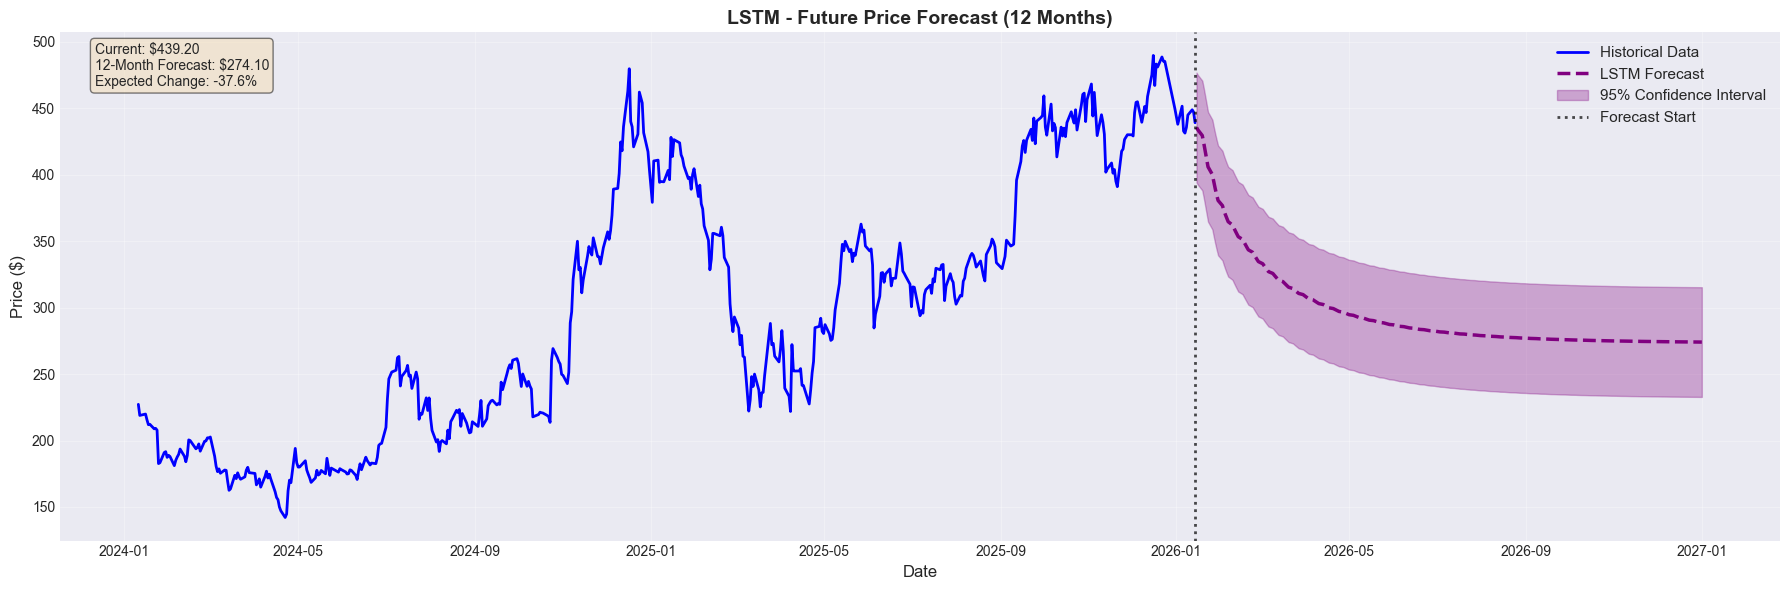

In [7]:
# Determine which model to visualize (use best model or both)
if best_model_name:
    models_to_plot = [best_model_name]
    print(f"Visualizing forecast from best model: {best_model_name}")
else:
    models_to_plot = []
    if arima_available:
        models_to_plot.append('ARIMA')
    if lstm_available:
        models_to_plot.append('LSTM')
    print(f"Visualizing forecasts from: {', '.join(models_to_plot)}")

# Create comprehensive forecast visualization
fig, axes = plt.subplots(len(models_to_plot), 1, figsize=(18, 6 * len(models_to_plot)))
if len(models_to_plot) == 1:
    axes = [axes]

for idx, model_name in enumerate(models_to_plot):
    ax = axes[idx]
    
    # Plot historical data (last 2 years for context)
    historical_period = close_prices[-504:]  # ~2 years
    ax.plot(historical_period.index, historical_period.values, 
            label='Historical Data', color='blue', linewidth=2)
    
    # Plot forecast based on model
    if model_name == 'ARIMA' and arima_available:
        forecast_series = arima_future_forecast
        lower_bound = arima_future_lower
        upper_bound = arima_future_upper
        forecast_color = 'red'
    elif model_name == 'LSTM' and lstm_available:
        forecast_series = lstm_future_forecast
        lower_bound = lstm_future_lower
        upper_bound = lstm_future_upper
        forecast_color = 'purple'
    else:
        continue
    
    # Plot forecast mean
    ax.plot(forecast_series.index, forecast_series.values, 
            label=f'{model_name} Forecast', color=forecast_color, linewidth=2.5, linestyle='--')
    
    # Plot confidence intervals
    ax.fill_between(forecast_series.index, lower_bound.values, upper_bound.values,
                     alpha=0.3, color=forecast_color, label='95% Confidence Interval')
    
    # Add vertical line separating historical and forecast
    last_historical_date = close_prices.index[-1]
    ax.axvline(x=last_historical_date, color='black', linestyle=':', linewidth=2,
               label='Forecast Start', alpha=0.7)
    
    # Formatting
    ax.set_title(f'{model_name} - Future Price Forecast (12 Months)', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price ($)', fontsize=12)
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Add text annotation with key forecast info
    final_price = forecast_series.iloc[-1]
    current_price = close_prices.iloc[-1]
    pct_change = ((final_price / current_price) - 1) * 100
    
    textstr = f'Current: ${current_price:.2f}\n12-Month Forecast: ${final_price:.2f}\nExpected Change: {pct_change:+.1f}%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props, family='sans-serif')

plt.tight_layout()
plt.show()

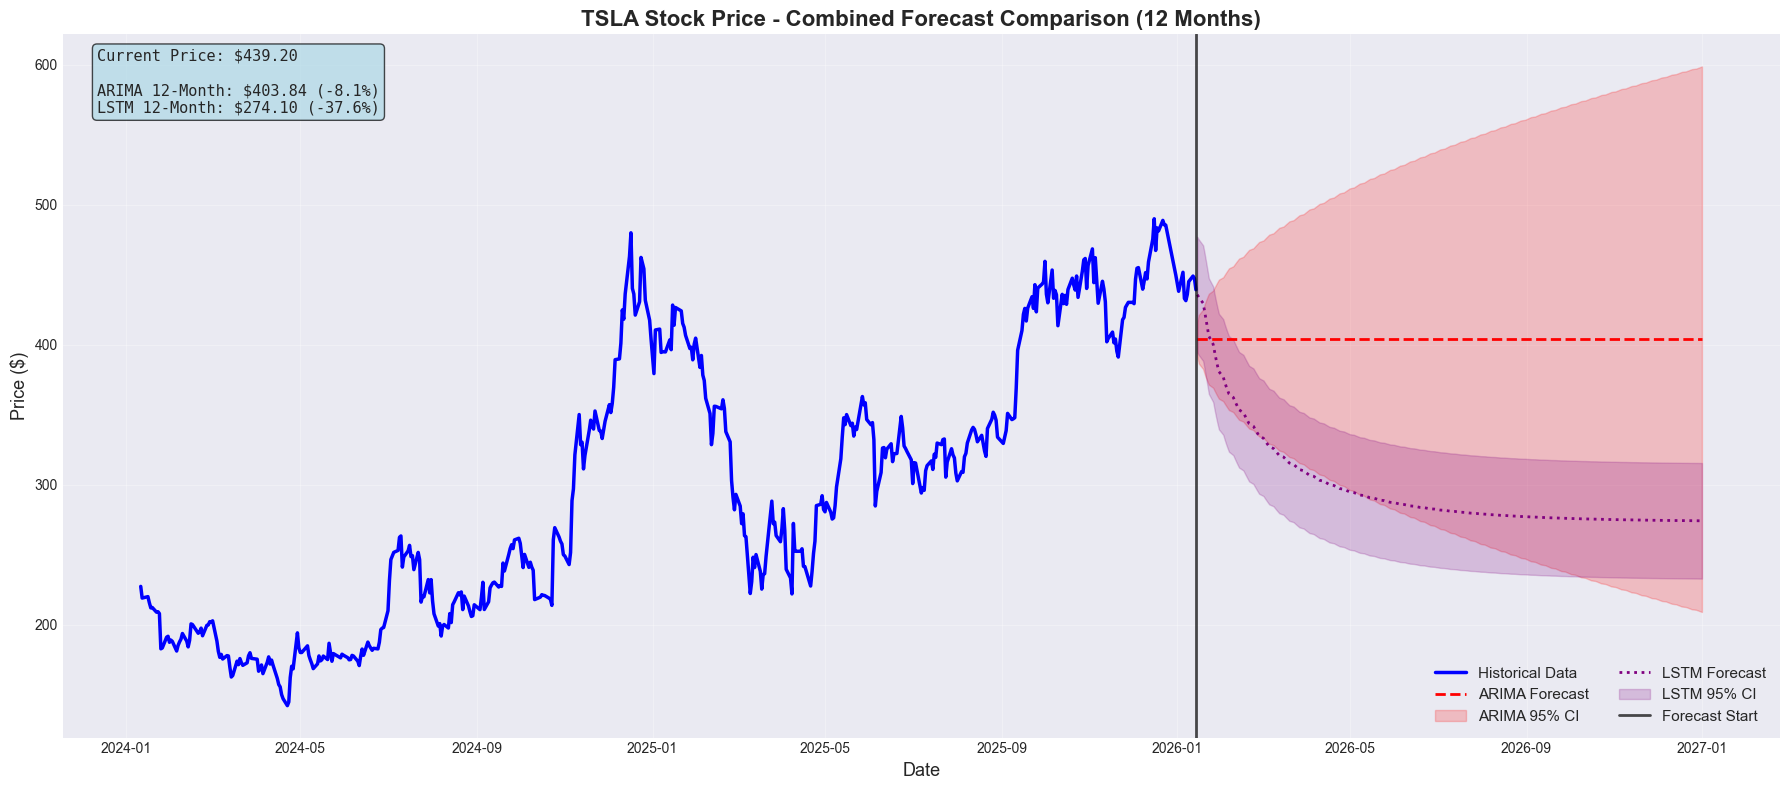

In [8]:
# Create a combined plot showing both models (if both available)
if arima_available and lstm_available:
    fig, ax = plt.subplots(figsize=(18, 8))
    
    # Plot historical data (last 2 years)
    historical_period = close_prices[-504:]
    ax.plot(historical_period.index, historical_period.values, 
            label='Historical Data', color='blue', linewidth=2.5)
    
    # Plot ARIMA forecast
    ax.plot(arima_future_forecast.index, arima_future_forecast.values,
            label='ARIMA Forecast', color='red', linewidth=2, linestyle='--')
    ax.fill_between(arima_future_forecast.index, arima_future_lower.values, 
                     arima_future_upper.values, alpha=0.2, color='red', 
                     label='ARIMA 95% CI')
    
    # Plot LSTM forecast
    ax.plot(lstm_future_forecast.index, lstm_future_forecast.values,
            label='LSTM Forecast', color='purple', linewidth=2, linestyle=':')
    ax.fill_between(lstm_future_forecast.index, lstm_future_lower.values,
                     lstm_future_upper.values, alpha=0.2, color='purple',
                     label='LSTM 95% CI')
    
    # Add vertical line
    last_historical_date = close_prices.index[-1]
    ax.axvline(x=last_historical_date, color='black', linestyle='-', linewidth=2,
               label='Forecast Start', alpha=0.7)
    
    # Formatting
    ax.set_title('TSLA Stock Price - Combined Forecast Comparison (12 Months)', 
                 fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=13)
    ax.set_ylabel('Price ($)', fontsize=13)
    ax.legend(loc='best', fontsize=11, ncol=2)
    ax.grid(True, alpha=0.3)
    
    # Add comparison text
    current_price = close_prices.iloc[-1]
    arima_final = arima_future_forecast.iloc[-1]
    lstm_final = lstm_future_forecast.iloc[-1]
    
    textstr = f'Current Price: ${current_price:.2f}\n\n'
    textstr += f'ARIMA 12-Month: ${arima_final:.2f} ({((arima_final/current_price)-1)*100:+.1f}%)\n'
    textstr += f'LSTM 12-Month: ${lstm_final:.2f} ({((lstm_final/current_price)-1)*100:+.1f}%)'
    
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.7)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=props, family='monospace')
    
    plt.tight_layout()
    plt.show()
else:
    print("Both models needed for comparison plot. Currently available:", 
          "ARIMA" if arima_available else "", "LSTM" if lstm_available else "")

## 4. Trend Analysis

In [9]:
# Analyze forecast trends
print("="*70)
print("TREND ANALYSIS")
print("="*70)

# Determine which forecast to analyze
if best_model_name == 'ARIMA' and arima_available:
    forecast_to_analyze = arima_future_forecast
    lower_bound = arima_future_lower
    upper_bound = arima_future_upper
    model_name = 'ARIMA'
elif best_model_name == 'LSTM' and lstm_available:
    forecast_to_analyze = lstm_future_forecast
    lower_bound = lstm_future_lower
    upper_bound = lstm_future_upper
    model_name = 'LSTM'
elif arima_available:
    forecast_to_analyze = arima_future_forecast
    lower_bound = arima_future_lower
    upper_bound = arima_future_upper
    model_name = 'ARIMA'
elif lstm_available:
    forecast_to_analyze = lstm_future_forecast
    lower_bound = lstm_future_lower
    upper_bound = lstm_future_upper
    model_name = 'LSTM'
else:
    print("No forecasts available for analysis")
    forecast_to_analyze = None

if forecast_to_analyze is not None:
    current_price = close_prices.iloc[-1]
    final_price = forecast_to_analyze.iloc[-1]
    
    # Calculate overall trend
    total_change = ((final_price / current_price) - 1) * 100
    monthly_change = total_change / 12
    
    # Calculate confidence interval width over time
    ci_width = (upper_bound - lower_bound) / forecast_to_analyze
    ci_width_pct = ci_width * 100
    
    # Split forecast into quarters
    q1_end = len(forecast_to_analyze) // 4
    q2_end = len(forecast_to_analyze) // 2
    q3_end = 3 * len(forecast_to_analyze) // 4
    
    q1_change = ((forecast_to_analyze.iloc[q1_end] / current_price) - 1) * 100
    q2_change = ((forecast_to_analyze.iloc[q2_end] / current_price) - 1) * 100
    q3_change = ((forecast_to_analyze.iloc[q3_end] / current_price) - 1) * 100
    q4_change = total_change
    
    print(f"\n{model_name} Forecast Analysis:")
    print("-" * 70)
    print(f"Current Price: ${current_price:.2f}")
    print(f"12-Month Forecast: ${final_price:.2f}")
    print(f"Expected Total Change: {total_change:+.2f}%")
    print(f"Average Monthly Change: {monthly_change:+.2f}%")
    
    print(f"\nQuarterly Forecast Breakdown:")
    print(f"  3-Month Forecast: ${forecast_to_analyze.iloc[q1_end]:.2f} ({q1_change:+.2f}%)")
    print(f"  6-Month Forecast: ${forecast_to_analyze.iloc[q2_end]:.2f} ({q2_change:+.2f}%)")
    print(f"  9-Month Forecast: ${forecast_to_analyze.iloc[q3_end]:.2f} ({q3_change:+.2f}%)")
    print(f"  12-Month Forecast: ${forecast_to_analyze.iloc[-1]:.2f} ({q4_change:+.2f}%)")
    
    print(f"\nConfidence Interval Analysis:")
    print(f"  Average CI Width: {ci_width_pct.mean():.2f}% of forecast")
    print(f"  Initial CI Width (Month 1): {ci_width_pct.iloc[0]:.2f}%")
    print(f"  Final CI Width (Month 12): {ci_width_pct.iloc[-1]:.2f}%")
    print(f"  CI Expansion: {ci_width_pct.iloc[-1] - ci_width_pct.iloc[0]:+.2f} percentage points")
    
    # Determine trend direction
    if total_change > 5:
        trend_direction = "STRONG UPWARD"
        trend_emoji = "📈"
    elif total_change > 0:
        trend_direction = "MODERATE UPWARD"
        trend_emoji = "📊"
    elif total_change > -5:
        trend_direction = "STABLE/SLIGHT DOWNWARD"
        trend_emoji = "➡️"
    else:
        trend_direction = "DOWNWARD"
        trend_emoji = "📉"
    
    print(f"\n{trend_emoji} Overall Trend: {trend_direction}")
    
    # Check for anomalies
    price_changes = forecast_to_analyze.pct_change().dropna()
    volatility = price_changes.std() * np.sqrt(252) * 100  # Annualized volatility
    
    print(f"\nForecast Volatility (Annualized): {volatility:.2f}%")
    
    if volatility > 50:
        print("  ⚠️ HIGH VOLATILITY expected in forecast period")
    elif volatility > 30:
        print("  ⚡ MODERATE VOLATILITY expected")
    else:
        print("  ✓ RELATIVELY STABLE forecast")

TREND ANALYSIS

LSTM Forecast Analysis:
----------------------------------------------------------------------
Current Price: $439.20
12-Month Forecast: $274.10
Expected Total Change: -37.59%
Average Monthly Change: -3.13%

Quarterly Forecast Breakdown:
  3-Month Forecast: $301.74 (-31.30%)
  6-Month Forecast: $280.96 (-36.03%)
  9-Month Forecast: $275.61 (-37.25%)
  12-Month Forecast: $274.10 (-37.59%)

Confidence Interval Analysis:
  Average CI Width: 28.13% of forecast
  Initial CI Width (Month 1): 18.96%
  Final CI Width (Month 12): 30.13%
  CI Expansion: +11.17 percentage points

📉 Overall Trend: DOWNWARD

Forecast Volatility (Annualized): 4.70%
  ✓ RELATIVELY STABLE forecast


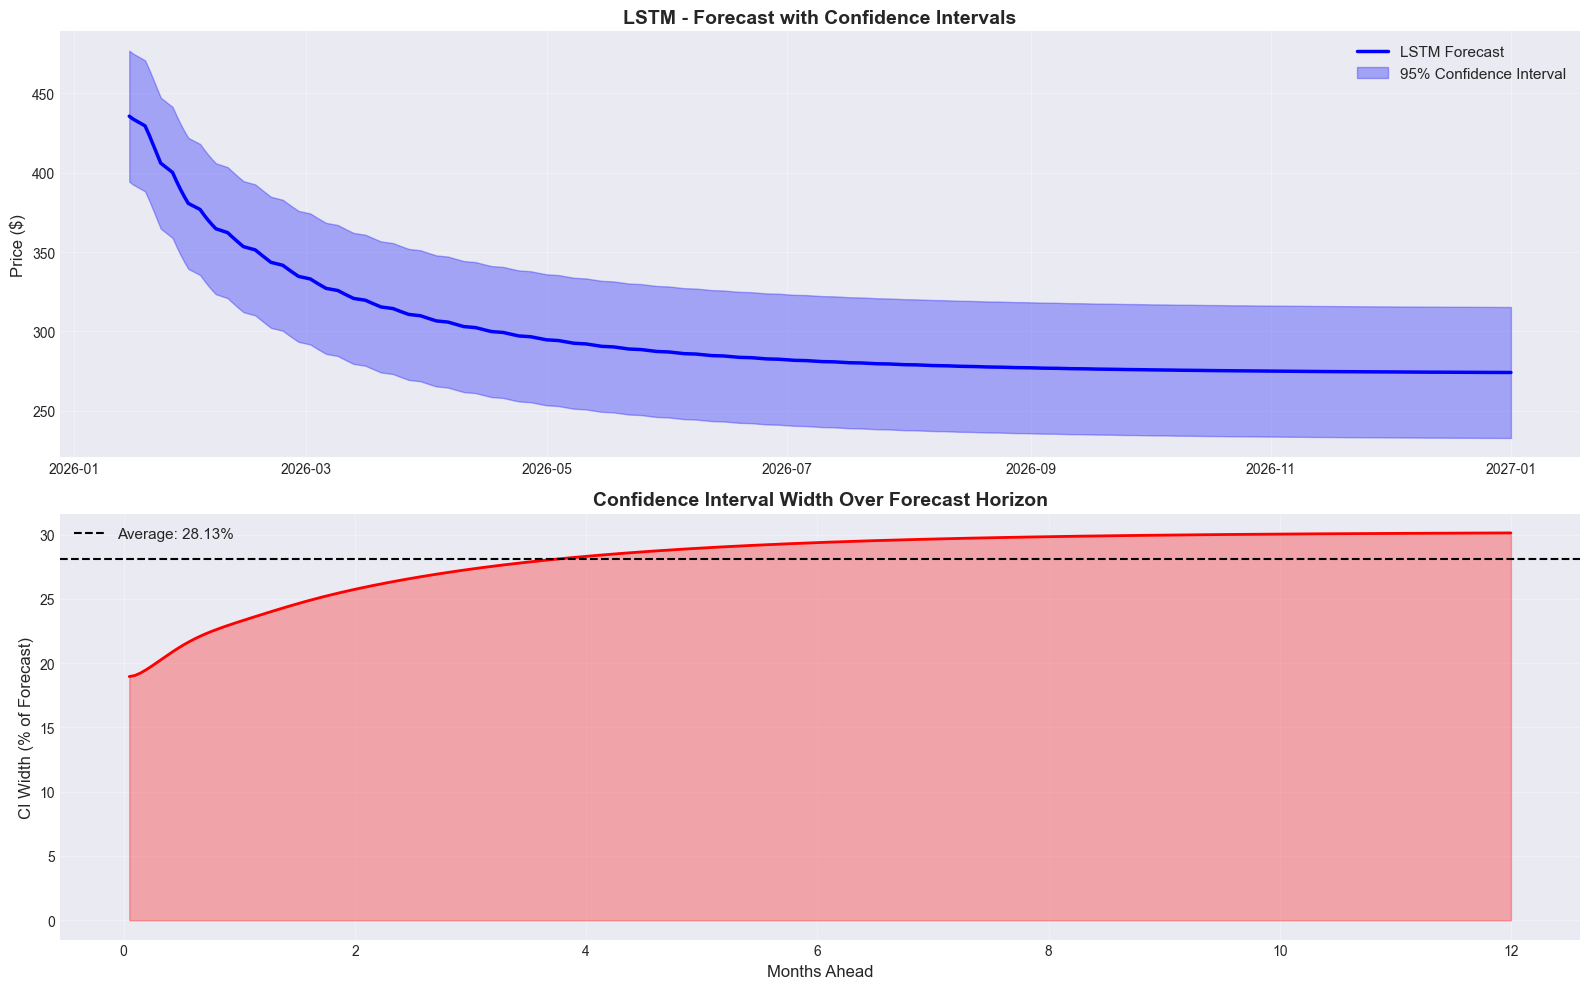


CONFIDENCE INTERVAL INTERPRETATION:

    The confidence interval width indicates forecast uncertainty:
    
    • Narrow CI (low %) = Higher confidence, more reliable forecast
    • Wide CI (high %) = Lower confidence, more uncertainty
    
    As the forecast horizon increases:
    • CI width typically EXPANDS (uncertainty grows)
    • Short-term forecasts (1-3 months) are more reliable
    • Long-term forecasts (9-12 months) have higher uncertainty
    
    This is expected behavior - predicting further into the future
    inherently involves more uncertainty due to:
    - Accumulation of prediction errors
    - Unknown future events
    - Market volatility
    - Model limitations
    


In [10]:
# Visualize confidence interval width over time
if forecast_to_analyze is not None:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
    
    # Plot 1: Forecast with CI width visualization
    ax1.plot(forecast_to_analyze.index, forecast_to_analyze.values,
             label=f'{model_name} Forecast', color='blue', linewidth=2.5)
    ax1.fill_between(forecast_to_analyze.index, lower_bound.values, upper_bound.values,
                      alpha=0.3, color='blue', label='95% Confidence Interval')
    ax1.set_title(f'{model_name} - Forecast with Confidence Intervals', 
                   fontsize=14, fontweight='bold')
    ax1.set_ylabel('Price ($)', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Confidence interval width over time
    months = np.arange(1, len(ci_width_pct) + 1) / 21  # Convert to months
    ax2.plot(months, ci_width_pct.values, color='red', linewidth=2)
    ax2.fill_between(months, 0, ci_width_pct.values, alpha=0.3, color='red')
    ax2.set_title('Confidence Interval Width Over Forecast Horizon', 
                   fontsize=14, fontweight='bold')
    ax2.set_xlabel('Months Ahead', fontsize=12)
    ax2.set_ylabel('CI Width (% of Forecast)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=ci_width_pct.mean(), color='black', linestyle='--', 
                label=f'Average: {ci_width_pct.mean():.2f}%', linewidth=1.5)
    ax2.legend(fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*70)
    print("CONFIDENCE INTERVAL INTERPRETATION:")
    print("="*70)
    print("""
    The confidence interval width indicates forecast uncertainty:
    
    • Narrow CI (low %) = Higher confidence, more reliable forecast
    • Wide CI (high %) = Lower confidence, more uncertainty
    
    As the forecast horizon increases:
    • CI width typically EXPANDS (uncertainty grows)
    • Short-term forecasts (1-3 months) are more reliable
    • Long-term forecasts (9-12 months) have higher uncertainty
    
    This is expected behavior - predicting further into the future
    inherently involves more uncertainty due to:
    - Accumulation of prediction errors
    - Unknown future events
    - Market volatility
    - Model limitations
    """)

## 5. Market Opportunities and Risks Assessment

In [11]:
# Comprehensive opportunities and risks analysis
print("="*70)
print("MARKET OPPORTUNITIES AND RISKS ASSESSMENT")
print("="*70)

if forecast_to_analyze is not None:
    current_price = close_prices.iloc[-1]
    final_price = forecast_to_analyze.iloc[-1]
    max_price = forecast_to_analyze.max()
    min_price = forecast_to_analyze.min()
    
    # Calculate key metrics
    max_potential_gain = ((max_price / current_price) - 1) * 100
    max_potential_loss = ((min_price / current_price) - 1) * 100
    expected_return = ((final_price / current_price) - 1) * 100
    
    # Risk metrics
    lower_bound_min = lower_bound.min()
    upper_bound_max = upper_bound.max()
    
    print(f"\n📊 FORECAST SUMMARY")
    print("-" * 70)
    print(f"Current Price: ${current_price:.2f}")
    print(f"12-Month Forecast: ${final_price:.2f}")
    print(f"Expected Return: {expected_return:+.2f}%")
    print(f"\nPrice Range (95% CI):")
    print(f"  Lower Bound: ${lower_bound_min:.2f} ({((lower_bound_min/current_price)-1)*100:+.2f}%)")
    print(f"  Upper Bound: ${upper_bound_max:.2f} ({((upper_bound_max/current_price)-1)*100:+.2f}%)")
    print(f"  Forecast Range: ${min_price:.2f} - ${max_price:.2f}")
    
    print(f"\n💡 MARKET OPPORTUNITIES")
    print("-" * 70)
    opportunities = []
    
    if expected_return > 10:
        opportunities.append(f"• Strong growth potential: {expected_return:.1f}% expected return over 12 months")
    elif expected_return > 5:
        opportunities.append(f"• Moderate growth opportunity: {expected_return:.1f}% expected return")
    elif expected_return > 0:
        opportunities.append(f"• Positive outlook: {expected_return:.1f}% expected return")
    
    if max_potential_gain > 20:
        opportunities.append(f"• High upside potential: Up to {max_potential_gain:.1f}% gain possible")
    
    if upper_bound_max > current_price * 1.15:
        opportunities.append(f"• Bullish scenario: Could reach ${upper_bound_max:.2f} (upper CI)")
    
    # Check for upward trend
    price_changes = forecast_to_analyze.pct_change().dropna()
    positive_months = (price_changes > 0).sum()
    if positive_months > len(price_changes) * 0.6:
        opportunities.append(f"• Consistent upward momentum: {positive_months}/{len(price_changes)} months show positive movement")
    
    if opportunities:
        for opp in opportunities:
            print(opp)
    else:
        print("• Limited growth opportunities identified in current forecast")
    
    print(f"\n⚠️ RISKS AND CONCERNS")
    print("-" * 70)
    risks = []
    
    if expected_return < -5:
        risks.append(f"• Significant downside risk: {expected_return:.1f}% expected decline")
    elif expected_return < 0:
        risks.append(f"• Negative outlook: {expected_return:.1f}% expected return")
    
    if max_potential_loss < -20:
        risks.append(f"• High downside risk: Could decline up to {abs(max_potential_loss):.1f}%")
    
    if lower_bound_min < current_price * 0.85:
        risks.append(f"• Bearish scenario: Could fall to ${lower_bound_min:.2f} (lower CI)")
    
    # Volatility risk
    volatility = price_changes.std() * np.sqrt(252) * 100
    if volatility > 60:
        risks.append(f"• Extreme volatility expected: {volatility:.1f}% annualized volatility")
    elif volatility > 40:
        risks.append(f"• High volatility: {volatility:.1f}% annualized volatility")
    
    # Confidence interval width risk
    avg_ci_width = ci_width_pct.mean()
    if avg_ci_width > 30:
        risks.append(f"• High forecast uncertainty: Average CI width of {avg_ci_width:.1f}%")
    elif avg_ci_width > 20:
        risks.append(f"• Moderate forecast uncertainty: Average CI width of {avg_ci_width:.1f}%")
    
    # CI expansion risk
    ci_expansion = ci_width_pct.iloc[-1] - ci_width_pct.iloc[0]
    if ci_expansion > 10:
        risks.append(f"• Uncertainty increases significantly over time: CI expands by {ci_expansion:.1f} percentage points")
    
    if risks:
        for risk in risks:
            print(risk)
    else:
        print("• Relatively low risk profile based on forecast")
    
    print(f"\n📈 UNCERTAINTY ANALYSIS")
    print("-" * 70)
    print(f"Confidence Interval Characteristics:")
    print(f"  • Average Width: {ci_width_pct.mean():.2f}% of forecast value")
    print(f"  • Initial Width (Month 1): {ci_width_pct.iloc[0]:.2f}%")
    print(f"  • Final Width (Month 12): {ci_width_pct.iloc[-1]:.2f}%")
    print(f"  • Expansion Rate: {ci_expansion:+.2f} percentage points over 12 months")
    
    if ci_expansion > 5:
        print(f"\n  ⚠️ WARNING: Significant uncertainty expansion indicates:")
        print(f"     - Long-term forecasts are less reliable")
        print(f"     - Focus on short-term (1-3 month) forecasts for decision-making")
        print(f"     - Consider multiple scenarios and stress testing")
    elif ci_expansion > 2:
        print(f"\n  ⚡ MODERATE: Uncertainty increases over time as expected")
        print(f"     - Short-term forecasts (1-6 months) are more reliable")
        print(f"     - Long-term forecasts should be used with caution")
    else:
        print(f"\n  ✓ STABLE: Uncertainty remains relatively constant")
        print(f"     - Forecast reliability is consistent across time horizon")
    
    print(f"\n💼 RECOMMENDATIONS FOR GMF INVESTMENTS")
    print("-" * 70)
    
    recommendations = []
    
    if expected_return > 10 and volatility < 40:
        recommendations.append("• STRONG BUY: High expected return with manageable risk")
    elif expected_return > 5:
        recommendations.append("• BUY: Positive expected return, suitable for growth portfolios")
    elif expected_return > 0:
        recommendations.append("• HOLD: Modest positive outlook, maintain current position")
    elif expected_return > -5:
        recommendations.append("• CAUTION: Negative outlook, consider reducing exposure")
    else:
        recommendations.append("• SELL: Significant downside risk expected")
    
    if avg_ci_width < 15:
        recommendations.append("• High confidence in forecast - suitable for active trading strategies")
    elif avg_ci_width < 25:
        recommendations.append("• Moderate confidence - use for portfolio allocation decisions")
    else:
        recommendations.append("• Low confidence - use forecasts as one input among many")
    
    if ci_expansion > 5:
        recommendations.append("• Focus on short-term (1-3 month) forecasts for tactical decisions")
        recommendations.append("• Use long-term forecasts for strategic planning only")
    
    if volatility > 50:
        recommendations.append("• High volatility expected - implement stop-loss strategies")
        recommendations.append("• Consider position sizing based on risk tolerance")
    
    for rec in recommendations:
        print(rec)

MARKET OPPORTUNITIES AND RISKS ASSESSMENT

📊 FORECAST SUMMARY
----------------------------------------------------------------------
Current Price: $439.20
12-Month Forecast: $274.10
Expected Return: -37.59%

Price Range (95% CI):
  Lower Bound: $232.81 (-46.99%)
  Upper Bound: $476.95 (+8.60%)
  Forecast Range: $274.10 - $435.66

💡 MARKET OPPORTUNITIES
----------------------------------------------------------------------
• Limited growth opportunities identified in current forecast

⚠️ RISKS AND CONCERNS
----------------------------------------------------------------------
• Significant downside risk: -37.6% expected decline
• High downside risk: Could decline up to 37.6%
• Bearish scenario: Could fall to $232.81 (lower CI)
• Moderate forecast uncertainty: Average CI width of 28.1%
• Uncertainty increases significantly over time: CI expands by 11.2 percentage points

📈 UNCERTAINTY ANALYSIS
----------------------------------------------------------------------
Confidence Interval Cha

In [12]:
print("="*70)
print("CRITICAL ASSESSMENT OF FORECAST RELIABILITY")
print("="*70)

print("""
╔══════════════════════════════════════════════════════════════════════╗
║                    FORECAST RELIABILITY ANALYSIS                     ║
╚══════════════════════════════════════════════════════════════════════╝

1. SHORT-TERM FORECASTS (1-3 Months)
   ─────────────────────────────────
   Reliability: HIGH to MODERATE
   
   Strengths:
   • Closer to historical patterns
   • Less accumulation of prediction errors
   • Confidence intervals are narrower
   • More actionable for tactical decisions
   
   Limitations:
   • Still subject to market shocks
   • Model may miss short-term volatility spikes
   • News events can cause sudden deviations
   
   Use Case: Tactical trading, short-term position adjustments
   
   
2. MEDIUM-TERM FORECASTS (3-6 Months)
   ───────────────────────────────────
   Reliability: MODERATE
   
   Strengths:
   • Balance between accuracy and forward-looking
   • Captures medium-term trends
   • Useful for portfolio rebalancing
   
   Limitations:
   • Uncertainty increases
   • Confidence intervals widen
   • Model assumptions become less reliable
   
   Use Case: Portfolio allocation, strategic planning
   
   
3. LONG-TERM FORECASTS (6-12 Months)
   ─────────────────────────────────
   Reliability: LOW to MODERATE
   
   Strengths:
   • Provides directional guidance
   • Useful for strategic planning
   • Captures long-term trends
   
   Limitations:
   • High uncertainty (wide confidence intervals)
   • Prediction errors accumulate
   • Model limitations become more apparent
   • External factors dominate
   
   Use Case: Strategic planning, scenario analysis
   
   
4. CONFIDENCE INTERVAL INTERPRETATION
   ───────────────────────────────────
   
   Narrow CI (< 15% width):
   • High confidence in forecast
   • Model is relatively certain
   • Suitable for active decision-making
   
   Moderate CI (15-25% width):
   • Moderate confidence
   • Some uncertainty present
   • Use with caution, consider multiple scenarios
   
   Wide CI (> 25% width):
   • Low confidence
   • High uncertainty
   • Use primarily for directional guidance
   • Consider alternative scenarios
   
   
5. MODEL LIMITATIONS
   ──────────────────
   
   ARIMA Limitations:
   • Assumes linear relationships
   • Struggles with structural breaks
   • May miss regime changes
   • Limited ability to capture complex patterns
   
   LSTM Limitations:
   • Requires sufficient historical data
   • May overfit to training patterns
   • Struggles with unprecedented events
   • Black box nature limits interpretability
   
   General Limitations:
   • Cannot predict black swan events
   • Assumes historical patterns continue
   • External factors not incorporated
   • Market sentiment not captured
   
   
6. RECOMMENDATIONS FOR USE
   ────────────────────────
   
   ✓ DO:
   • Use forecasts as ONE input among many
   • Combine with fundamental analysis
   • Monitor actual vs. predicted performance
   • Update models regularly
   • Consider multiple scenarios
   • Use confidence intervals for risk management
   
   ✗ DON'T:
   • Rely solely on forecasts for decisions
   • Ignore confidence intervals
   • Use long-term forecasts for short-term trading
   • Assume forecasts are guarantees
   • Ignore model limitations
   • Disregard external factors
   
   
7. FORECAST RELIABILITY OVER TIME HORIZON
   ──────────────────────────────────────
""")

if forecast_to_analyze is not None:
    # Calculate reliability metrics by time horizon
    horizons = {
        '1 Month': 21,
        '3 Months': 63,
        '6 Months': 126,
        '9 Months': 189,
        '12 Months': 252
    }
    
    print("   Time Horizon | CI Width | Reliability | Use Case")
    print("   " + "-" * 60)
    
    for horizon_name, days in horizons.items():
        if days <= len(ci_width_pct):
            ci_w = ci_width_pct.iloc[days-1]
            
            if ci_w < 15:
                reliability = "HIGH"
                use_case = "Active Trading"
            elif ci_w < 25:
                reliability = "MODERATE"
                use_case = "Portfolio Allocation"
            else:
                reliability = "LOW"
                use_case = "Strategic Planning"
            
            print(f"   {horizon_name:12s} | {ci_w:7.2f}% | {reliability:11s} | {use_case}")
    
    print("\n" + "="*70)
    print("CONCLUSION")
    print("="*70)
    print(f"""
    Based on the {model_name} forecast analysis:
    
    • Forecast reliability DECREASES as time horizon INCREASES
    • Short-term forecasts (1-3 months) are most reliable
    • Long-term forecasts (9-12 months) should be used for directional guidance only
    • Confidence intervals provide crucial context for decision-making
    • Always combine forecasts with other analysis methods
    
    For GMF Investments:
    → Use short-term forecasts for tactical decisions
    → Use medium-term forecasts for portfolio allocation
    → Use long-term forecasts for strategic planning and scenario analysis
    → Always consider confidence intervals in risk management
    → Regularly update and validate models
    """)

CRITICAL ASSESSMENT OF FORECAST RELIABILITY

╔══════════════════════════════════════════════════════════════════════╗
║                    FORECAST RELIABILITY ANALYSIS                     ║
╚══════════════════════════════════════════════════════════════════════╝

1. SHORT-TERM FORECASTS (1-3 Months)
   ─────────────────────────────────
   Reliability: HIGH to MODERATE
   
   Strengths:
   • Closer to historical patterns
   • Less accumulation of prediction errors
   • Confidence intervals are narrower
   • More actionable for tactical decisions
   
   Limitations:
   • Still subject to market shocks
   • Model may miss short-term volatility spikes
   • News events can cause sudden deviations
   
   Use Case: Tactical trading, short-term position adjustments
   
   
2. MEDIUM-TERM FORECASTS (3-6 Months)
   ───────────────────────────────────
   Reliability: MODERATE
   
   Strengths:
   • Balance between accuracy and forward-looking
   • Captures medium-term trends
   • Useful for port

In [14]:
# Save forecasts for future reference
print("="*60)
print("SAVING FORECASTS AND ANALYSIS")
print("="*60)

# Create comprehensive forecast dataframe
forecast_data = {}

if arima_available:
    forecast_data['ARIMA_Forecast'] = arima_future_forecast
    forecast_data['ARIMA_Lower_CI'] = arima_future_lower
    forecast_data['ARIMA_Upper_CI'] = arima_future_upper

if lstm_available:
    forecast_data['LSTM_Forecast'] = lstm_future_forecast
    forecast_data['LSTM_Lower_CI'] = lstm_future_lower
    forecast_data['LSTM_Upper_CI'] = lstm_future_upper

if forecast_data:
    forecast_df = pd.DataFrame(forecast_data)
    forecast_df.to_csv('../data/processed/future_forecasts.csv')
    print("✓ Future forecasts saved to '../data/processed/future_forecasts.csv'")

# Save summary report
summary_report = {
    'current_price': float(close_prices.iloc[-1]),
    'forecast_date': datetime.now().strftime('%Y-%m-%d'),
    'forecast_horizon_months': 12,
    'model_used': model_name if forecast_to_analyze is not None else 'N/A'
}

if forecast_to_analyze is not None:
    summary_report.update({
        'final_forecast_price': float(forecast_to_analyze.iloc[-1]),
        'expected_return_pct': float(((forecast_to_analyze.iloc[-1] / close_prices.iloc[-1]) - 1) * 100),
        'avg_ci_width_pct': float(ci_width_pct.mean()),
        'ci_expansion_pct': float(ci_width_pct.iloc[-1] - ci_width_pct.iloc[0]),
        'forecast_volatility_pct': float(price_changes.std() * np.sqrt(252) * 100)
    })

import json
with open('../data/processed/forecast_summary.json', 'w') as f:
    json.dump(summary_report, f, indent=4)
print("✓ Forecast summary saved to '../data/processed/forecast_summary.json'")

SAVING FORECASTS AND ANALYSIS
✓ Future forecasts saved to '../data/processed/future_forecasts.csv'
✓ Forecast summary saved to '../data/processed/forecast_summary.json'
